In [171]:
# General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Sklearn Libraries
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [172]:
# Reading dataset and pre-assigning highly correlated variables for convenience (see below)
d = pd.read_csv('../data/dataset.csv', delimiter = ",")
d_top = d[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']]

## 1. Knowing the Data

In [173]:
# Describing outcome variable
d['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: xlabel='SalePrice', ylabel='Count'>

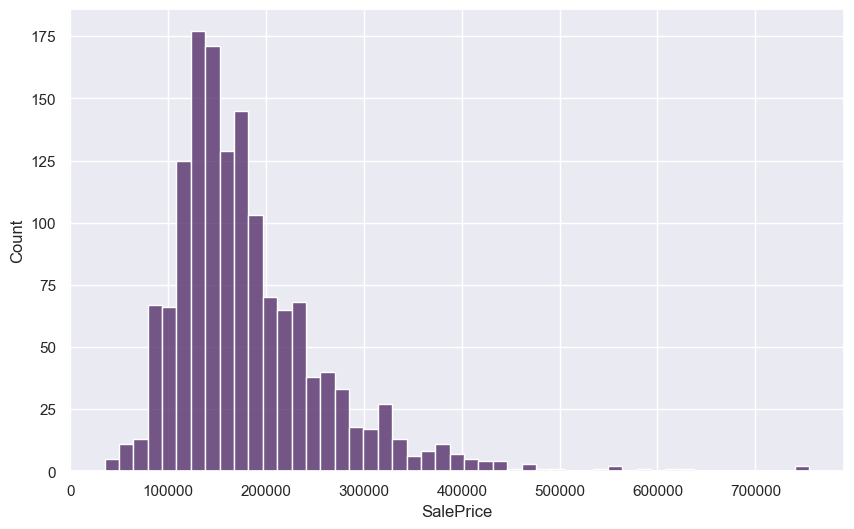

In [174]:
# Plotting histrogram of outcome variable
f, ax = plt.subplots(figsize=(10, 6))
sns.histplot(d['SalePrice'], color='#4B2362')

In [175]:
# Highlighting skewness of outcome variable due to positive skewness
#d.agg(['skew','kurt'])
pd.concat([d['SalePrice'].agg(['skew','kurt'])],keys=['SalePrice'],axis=1).transpose()

,skew,kurt
SalePrice,1.882876,6.536282


In [176]:
# Dropping variable 'ID' due to no use for model
d = d.drop(columns=['Id'])

## 2. Data Preparation

### Checking all variables according to their type:

In [177]:
# Checking all categorical data
d.select_dtypes(include=['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [178]:
# Checking all numerical data (int and float)
d.select_dtypes(include=['float64','int64']).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [179]:
# Printing the amount of features available in total
count_numerical = len(d.select_dtypes(include=['int64','float64']).columns)
count_categorical = len(d.select_dtypes(include=['object']).columns)
count_total = count_categorical + count_numerical
print('Total Features: ', count_categorical, 'categorical', '+',
      count_numerical, 'numerical', '=', count_total, 'features')

Total Features:  43 categorical + 37 numerical = 80 features


### Identifying highly correlated variables with the outcome variable:

/var/folders/5f/06bzwqjd1kl3lkb5zlxrzcp00000gn/T/ipykernel_33896/3350336724.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  d_correlation_matrix = d.corr()


<Axes: >

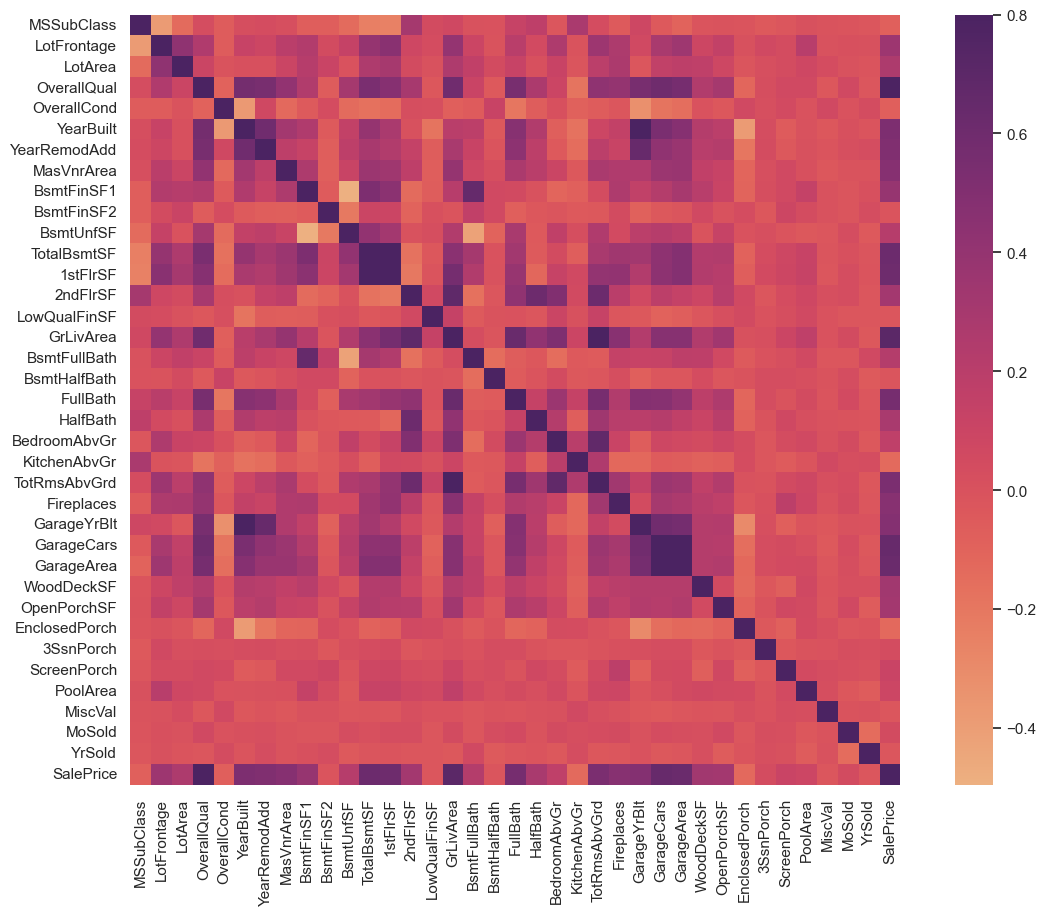

In [180]:
# Showing a correlation matrix heatmap of all variables
d_correlation_matrix = d.corr()
f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(d_correlation_matrix, vmax=.8, square=True, cmap="flare")

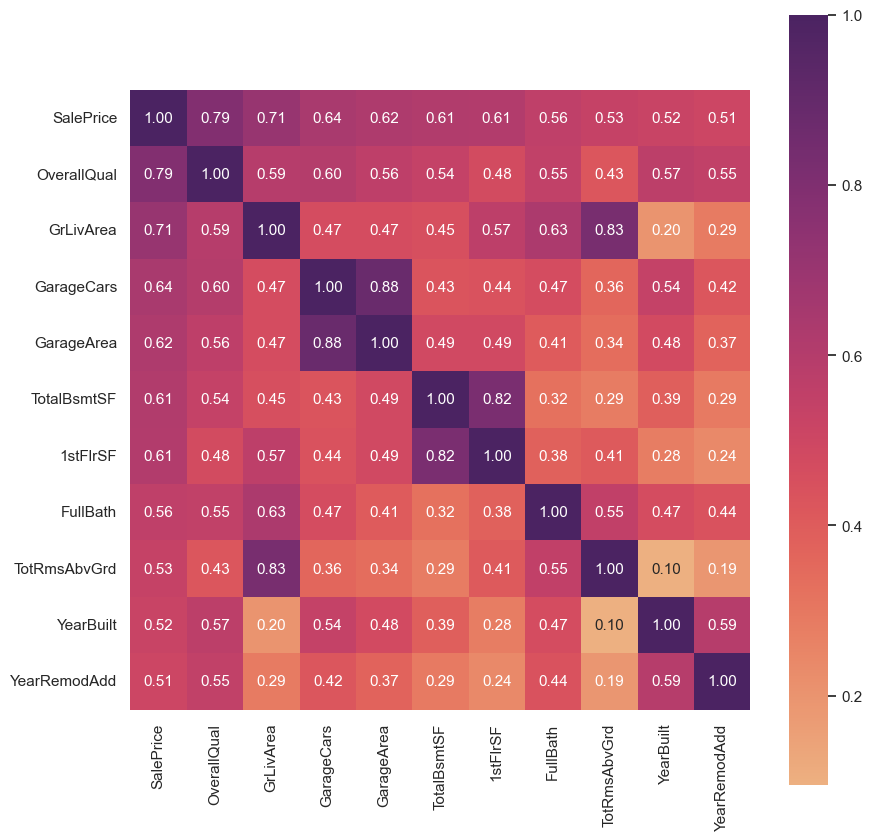

In [181]:
# Showing a correlation matrix heatmap of the eleven highest correlated variables with the outcome variable
columns = d_correlation_matrix.nlargest(11, 'SalePrice')['SalePrice'].index
d_top_correlation_matrix = np.corrcoef(d[columns].values.T)
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(10,10))
heatmap = sns.heatmap(d_top_correlation_matrix, cbar=True, annot=True, square=True, cmap="flare", fmt='.2f', annot_kws={'size': 11}, yticklabels=columns.values, xticklabels=columns.values)
plt.show()

In [182]:
# Showing the types of top 10 variables (excluding the outcome variable)
d_top.dtypes

SalePrice       int64
OverallQual     int64
GrLivArea       int64
GarageCars      int64
GarageArea      int64
TotalBsmtSF     int64
1stFlrSF        int64
FullBath        int64
TotRmsAbvGrd    int64
YearBuilt       int64
YearRemodAdd    int64
dtype: object

### The following ten variables show the highest correlation with our outcome variable "SalePrice":

The variable **"SalePrice"** will be excluded for this list as the variable is of course perfectly correlated to itself.

| Empty     | Variable      | Description                                                             |
| --------- | ------------- | ----------------------------------------------------------------------- |
| 1         | OverallQual   | Rates the overall material and finish of the house     |
| 2         | GrLivArea     | Above grade (ground) living area square feet    |
| 3         | GarageCars    | Size of garage in car capacity    |
| 4         | GarageArea    | Size of garage in square feet    |
| 5         | TotalBsmtSF   | Total square feet of basement area    |
| 6         | 1stFlrSF      | First Floor square feet    |
| 7         | FullBath      | Full bathrooms above grade   |
| 8         | TotRmsAbvGrd  | Total rooms above grade (does not include bathrooms)    |
| 9         | YearBuilt     | Original construction date    |
| 10        | YearRemodAdd  | Remodel date (same as construction date if no remodeling or additions)   |


### Plotting boxplots and scatterplots to identify outliers and anomalies:

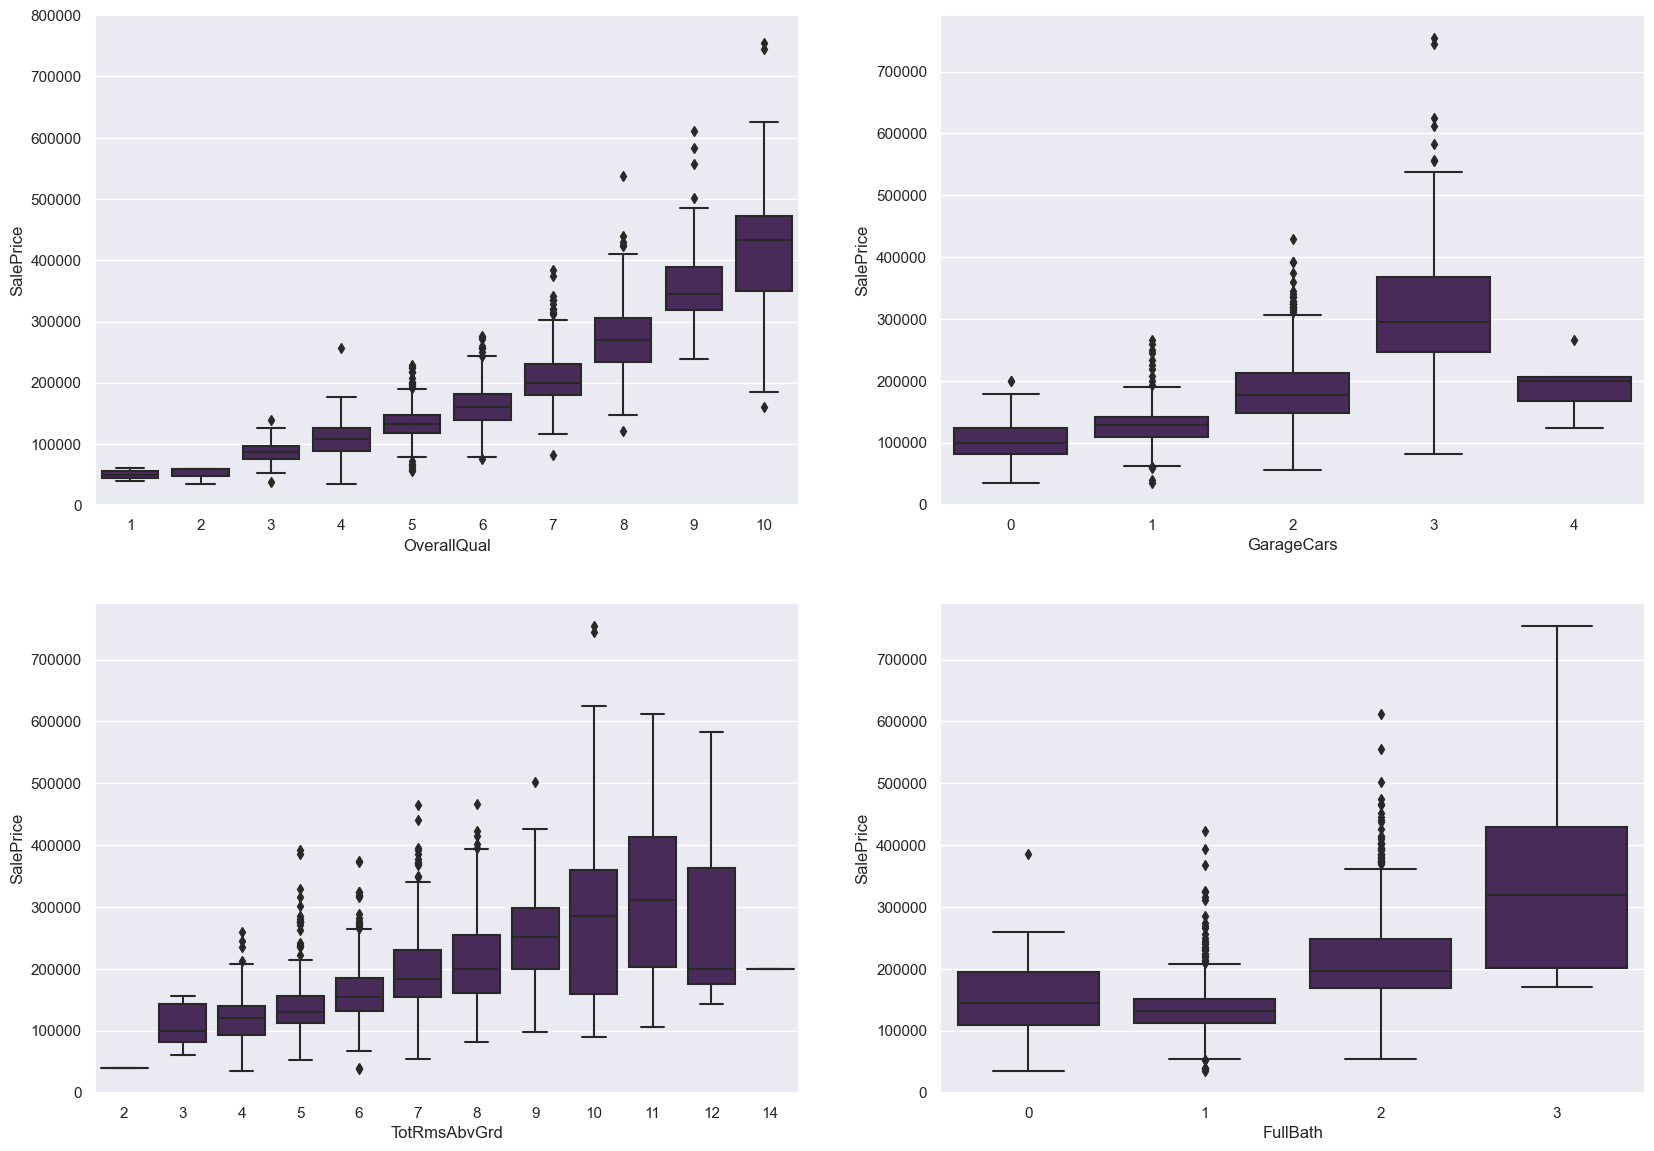

In [183]:
# Plotting the the first four selected variables in a boxplot to identify any anomalies
d_var_quality = pd.concat([d['SalePrice'], d['OverallQual']], axis=1)

# Creating the graph
f, ax = plt.subplots(2, 2, figsize=(20, 14))
f = sns.boxplot(x="OverallQual", y="SalePrice", data=d_var_quality, color='#4B2362', ax=ax[0][0])
f.axis(ymin=0, ymax=800000)

# Plotting "GarageCars" and "SalePrice"
f = sns.boxplot(x=d['GarageCars'], y=d['SalePrice'],color='#4B2362',ax=ax[0][1])

# Plotting "TotalRooms" and "SalePrice"
f = sns.boxplot(x=d['TotRmsAbvGrd'], y=d['SalePrice'],color='#4B2362',ax=ax[1][0])

# Plotting "TotalBathrooms" and "SalePrice"
f = sns.boxplot(x=d['FullBath'], y=d['SalePrice'],color='#4B2362',ax=ax[1][1])

For the variable **"OverallQual"**, it seems that potential buyers pay more for a better quality. 

For the variable **"GarageCars"**, it seems unnatural of receiving a lower price for the space of four rather than three vehicles in a garage and hence, this outlier shall be removed.

For the variable **"TotalRmsAbvGrd"**, it seems that potential buyers pay slightly less for more than 11 rooms.

For the variable **"FullBath"**, it seems that the more bathrooms, the higher the price.

(-0.5, 60.5, 0.0, 800000.0)

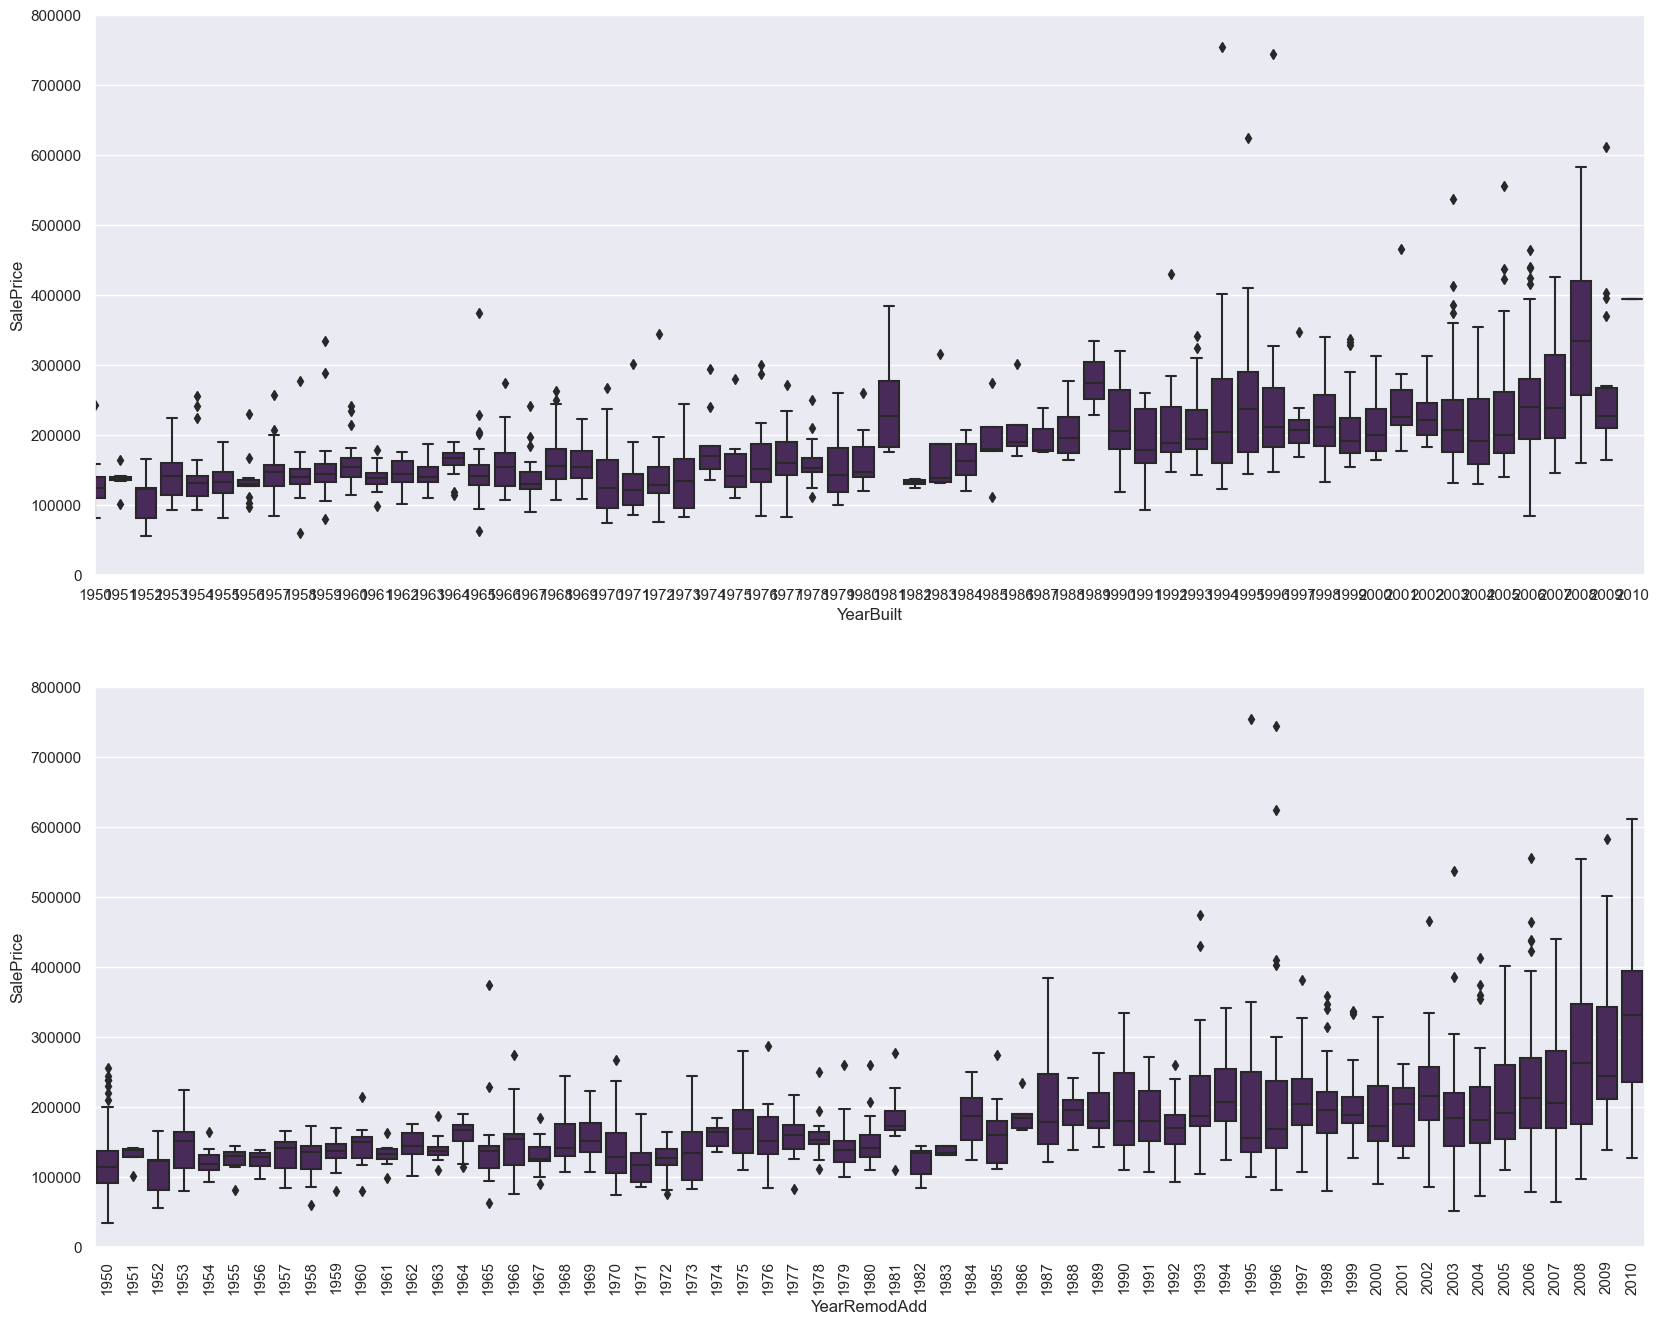

In [184]:
# Plotting two more selected variables in a boxplot to identify any anomalies
d_var_year = pd.concat([d['SalePrice'], d['YearBuilt']], axis=1)
d_var_remod = pd.concat([d['SalePrice'], d['YearRemodAdd']], axis=1)

# Creating the graph
f, ax = plt.subplots(2, 1, figsize=(20, 16))
plt.xticks(rotation=90)

# Plotting boxplots for year built and sales price
f = sns.boxplot(x="YearBuilt", y="SalePrice", data=d_var_year, color='#4B2362', ax=ax[0])
f.axis(ymin=0, ymax=800000,xmin=51)

# Plotting boxplots for year renovated and sales price
f = sns.boxplot(x='YearRemodAdd', y='SalePrice',data=d_var_remod, color='#4B2362',ax=ax[1])
f.axis(ymin=0, ymax=800000)

For the variable **"YearBuilt"**, it seems that the price decreases.

For the variable **"YearRemodAdd"**, it seems that the data is correlated to the previous variable.

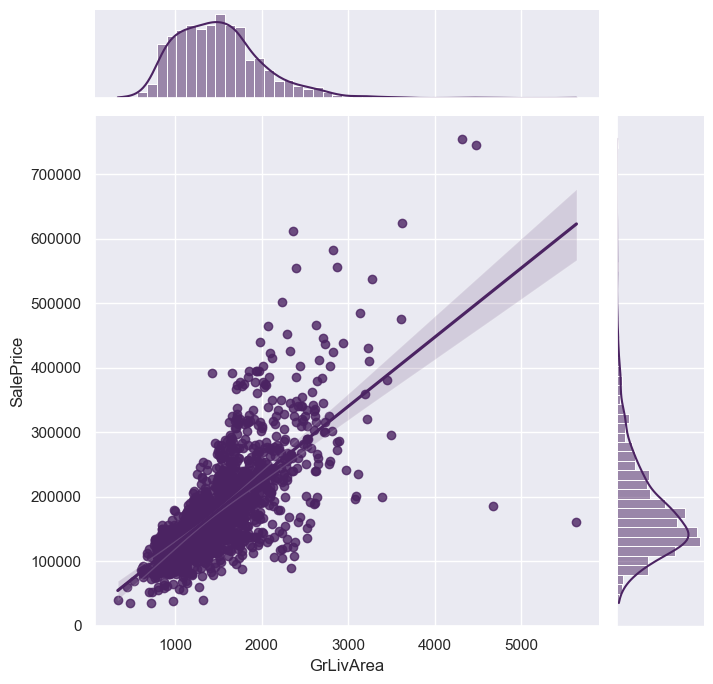

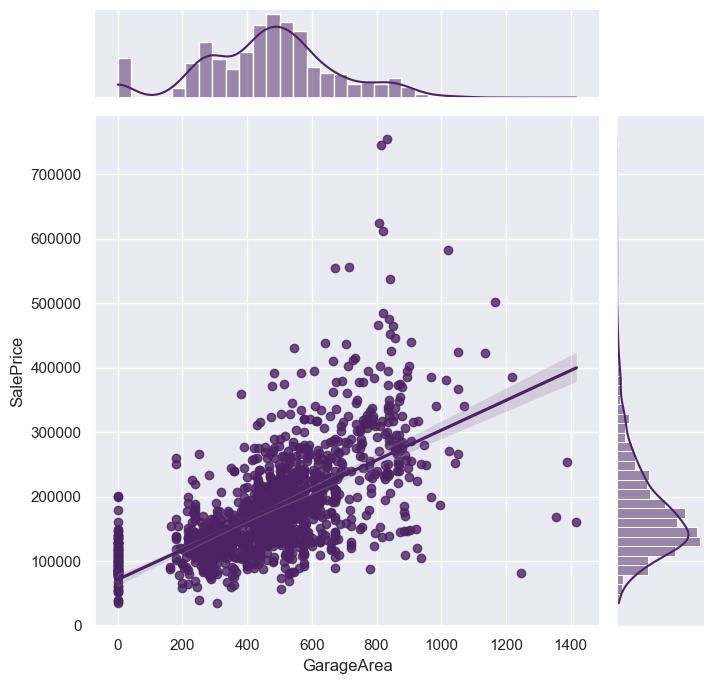

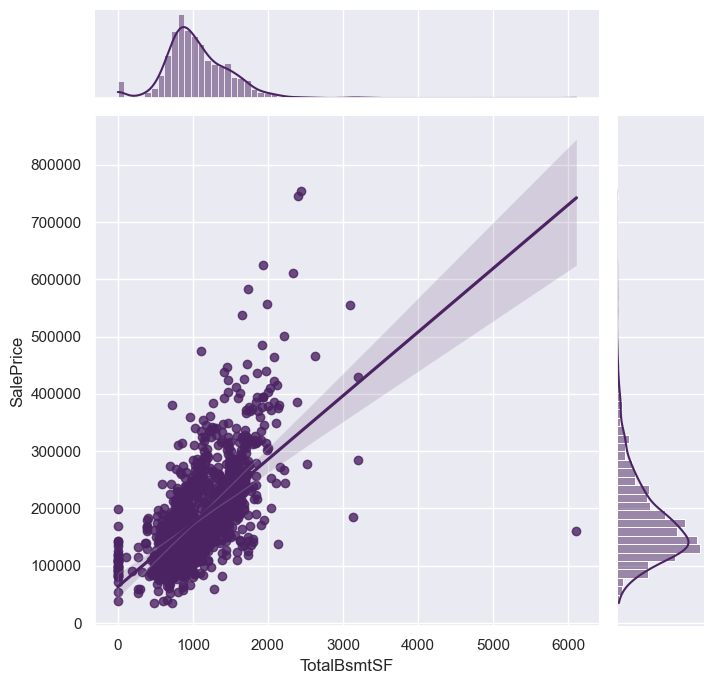

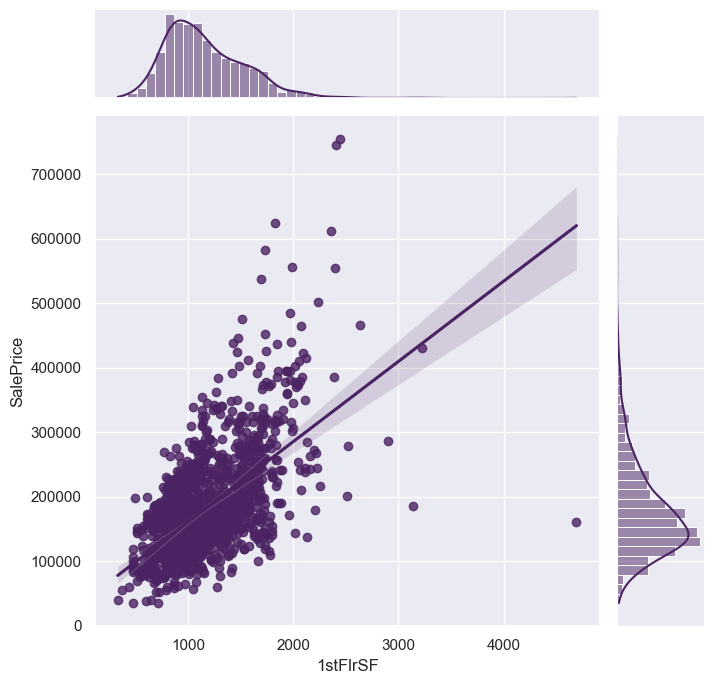

In [185]:
# Plotting joint plots for living area and sales price
sns.jointplot(x=d['GrLivArea'], y=d['SalePrice'], kind='reg', color='#4B2362', height=7)

# Plotting joint plots for garage area and sales price
sns.jointplot(x=d['GarageArea'], y=d['SalePrice'], kind='reg', color='#4B2362', height=7)

# Plotting joint plots for basement area and sales price
sns.jointplot(x=d['TotalBsmtSF'], y=d['SalePrice'], kind='reg', color='#4B2362', height=7)

# Plotting joint plots for first floor area and sales price
sns.jointplot(x=d['1stFlrSF'], y=d['SalePrice'], kind='reg', color='#4B2362', height=7)

For the variable **"GrLivArea"**, it seems that there might be two potential outliers on the right, lower side which shall be removed.

For the variable **"GarageArea"**, it seems that there might be two potential outliers on the right, lower side which shall be removed.

For the variable **"TotalBsmtSF"**, it seems that potential buyers pay more for more square feet in the basement area.

For the variable **"1stFlrSF"**, it seems that potential buyers pay more for more square feet in the first floor area.

## 3. Data Cleaning

### Checking and interpolating outliers:

<Axes: xlabel='GarageCars', ylabel='SalePrice'>

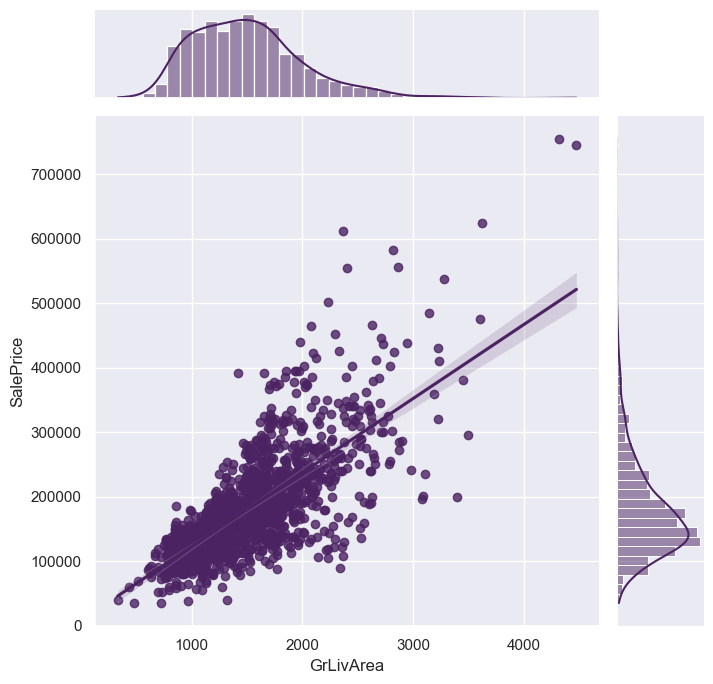

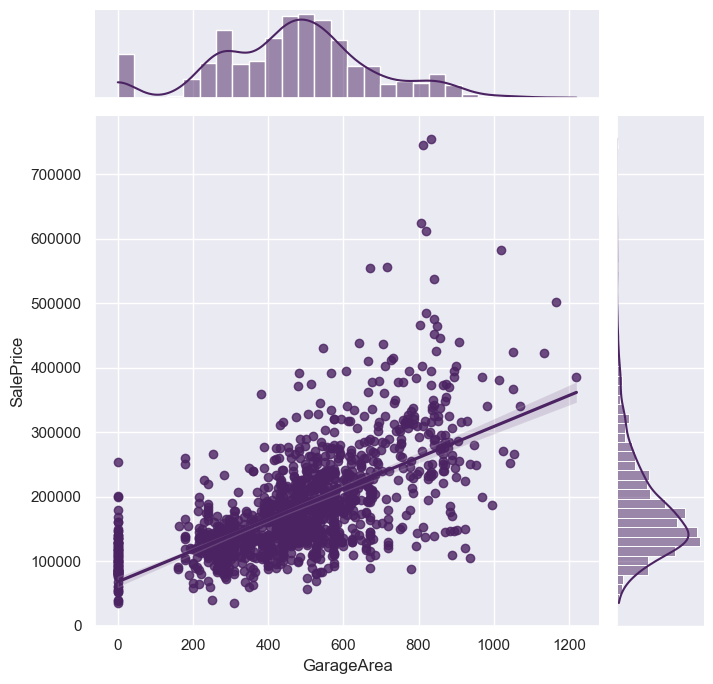

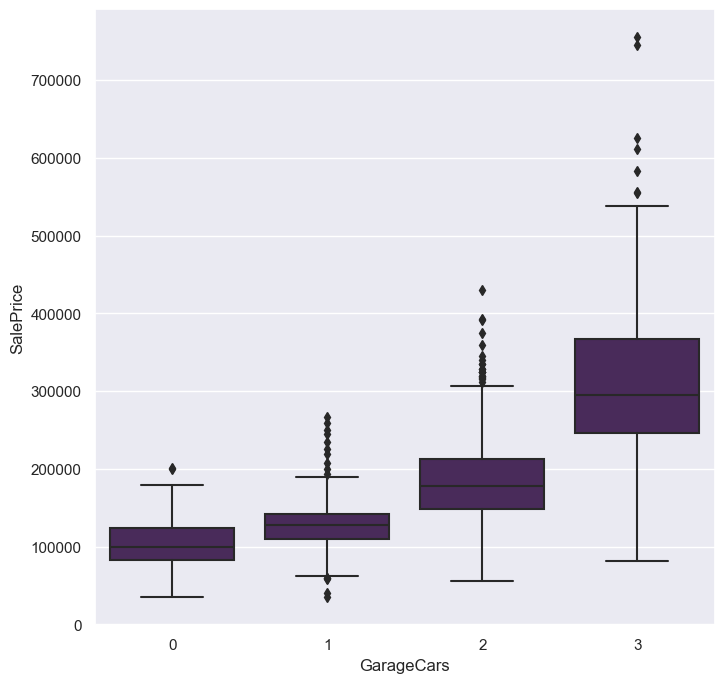

In [186]:
# Defining mode of living area and interpolating outliers
variable = 'GrLivArea'
mode = d[variable].mode()

d_livarea = d[(d[variable] > 4000) & (d['SalePrice'] < 300000)]
indices_outliers = d_livarea.head().index.tolist()
d.loc[indices_outliers,variable] = mode[0]

# Defining mode of garage area and interpolating outliers
variable = 'GarageArea'
mode = d[variable].mode()

d_garagearea = d[(d[variable] > 1100) & (d['SalePrice'] < 300000)]
indices_outliers = d_garagearea.head().index.tolist()
d.loc[indices_outliers,variable] = mode[0]

# Defining mode of garage cars and interpolating outliers
variable = 'GarageCars'
mode = d[variable].mode()

d_garagecars = d[(d[variable] > 3) & (d['SalePrice'] < 300000)]
indices_outliers = d_garagecars.head().index.tolist()
d.loc[indices_outliers,variable] = mode[0]

# Plotting joint plots for living area and sales price
sns.jointplot(x=d['GrLivArea'], y=d['SalePrice'], kind='reg', color='#4B2362', height=7)

# Plotting joint plots for garage area and sales price
sns.jointplot(x=d['GarageArea'], y=d['SalePrice'], kind='reg', color='#4B2362', height=7)

# Plotting joint plots for garagae cars and sales price
f, ax = plt.subplots(figsize=(8, 8))
sns.boxplot(x=d['GarageCars'], y=d['SalePrice'],color='#4B2362')

### Detecing null or empty values:

In [187]:
# Detecting the number of missing or null values per variable
pd.concat([d.isnull().sum(),d.isna().sum(min_count=1)],keys=['Nulls','Empty'],axis=1).sort_values(by='Nulls', ascending=False)[:20]

,Nulls,Empty
PoolQC,1453,1453
MiscFeature,1406,1406
Alley,1369,1369
Fence,1179,1179
FireplaceQu,690,690
LotFrontage,259,259
GarageYrBlt,81,81
GarageCond,81,81
GarageType,81,81
GarageFinish,81,81


### Imputing logic for missing or null values:

The following variables have at least one missing value. Hence, it is required to look into the data description and impute missing values. The following logic has been applied:

|               | Nulls and Empty   | Imputation                 |
| ------------- | ----------------- | --------------------- |
| PoolQC        | 1453              | NA = None (No Pool)          |
| MiscFeature   | 1406              | NA = None (No MiscFeature)   |
| Alley         | 1369              | NA = None (No Alley access)            |
| Fence	        | 1179              | NA = None (No Fence)            |
| FireplaceQu   | 690               | NA = None (No Fireplace)            |
| LotFrontage   | 259               | Drop variable            |
| GarageYrBlt   | 81                | NA = 0 (No Garage)            |
| GarageCond    | 81                | NA = None (No Garage)              |
| GarageType    | 81                | NA = None (No Garage)          |
| GarageFinish  | 81                | NA = None (No Garage)            |
| GarageQual    | 81                | NA = None (No Garage)            |
| BsmtFinType2  | 38                | NA = None        |  
| BsmtExposure  | 38                | NA = None            |
| BsmtQual      | 37                | NA = None            |
| BsmtCond      | 37                | NA = None            |
| BsmtFinType1  | 37                | NA = None          |
| MasVnrArea    | 8                 | NA = 0          |
| MasVnrType	| 8                 | NA = None          |
| Electrical    | 1                 | NA = 'SBrkr' (most frequent)          |

### Imputing missing or null values and dropping one variable:

In [188]:
d["PoolQC"] = d["PoolQC"].fillna("None")
d["MiscFeature"] = d["MiscFeature"].fillna("None")
d["Alley"] = d["Alley"].fillna("None")
d["Fence"] = d["Fence"].fillna("None")
d["FireplaceQu"] = d["FireplaceQu"].fillna("None")
d["GarageYrBlt"] = d["GarageYrBlt"].fillna(0)
d["GarageCond"] = d["GarageCond"].fillna("None")
d["GarageType"] = d["GarageType"].fillna("None")
d["GarageFinish"] = d["GarageFinish"].fillna("None")
d["GarageQual"] = d["GarageQual"].fillna("None")
d["BsmtFinType2"] = d["BsmtFinType2"].fillna("None")
d["BsmtExposure"] = d["BsmtExposure"].fillna("None")
d["BsmtCond"] = d["BsmtCond"].fillna("None")
d["BsmtQual"] = d["BsmtQual"].fillna("None")
d["BsmtFinType1"] = d["BsmtFinType1"].fillna("None")
d["MasVnrArea"] = d["BsmtCond"].fillna(0)
d["MasVnrType"] = d["BsmtCond"].fillna("None")
d["Electrical"] = d["Electrical"].fillna("SBrkr")
d.drop('LotFrontage', axis=1, inplace=True)

In [189]:
# Re-checking missing values
pd.concat([d.isnull().sum(),d.isna().sum(min_count=1)],keys=['Nulls','Empty'],axis=1).sort_values(by='Nulls', ascending=False)[:20]

,Nulls,Empty
MSSubClass,0,0
KitchenAbvGr,0,0
GarageYrBlt,0,0
GarageType,0,0
FireplaceQu,0,0
Fireplaces,0,0
Functional,0,0
TotRmsAbvGrd,0,0
KitchenQual,0,0
BedroomAbvGr,0,0


## 4. Feature Selection

### Dropping irrelevant columsn for model:

The following variables have a high correlation inbetween them which could worsen our model's accuracy:

1. **"GarageCars"** and **"GarageArea"**
2. **"TotalBsmtSF"** and **"1stFlSF"**
3. **"TotRmsAbvGrd"** and **"GrLivArea"**

Hence, the following variables will be dropped:

1. **"GarageCars"**
2. **"TotalBsmtSF"**
3. **"TotRmsAbvGrd"**


In [190]:
# Droping irrelevant columns
d = d.drop(columns=['GarageCars', 'TotalBsmtSF', 'TotRmsAbvGrd'])

## 5. Feature Transformation

### Checking the skewness of all selected numerical variables:

In [191]:
# Highlighting the skewness of the data from highest to lowest
pd.concat([d.agg(['skew'])],axis=1).transpose().sort_values(by='skew', ascending=False)

/var/folders/5f/06bzwqjd1kl3lkb5zlxrzcp00000gn/T/ipykernel_33896/1368346176.py:2: FutureWarning: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  pd.concat([d.agg(['skew'])],axis=1).transpose().sort_values(by='skew', ascending=False)


,skew
MiscVal,24.476794
PoolArea,14.828374
LotArea,12.207688
3SsnPorch,10.304342
LowQualFinSF,9.011341
KitchenAbvGr,4.488397
BsmtFinSF2,4.255261
ScreenPorch,4.122214
BsmtHalfBath,4.103403
EnclosedPorch,3.089872


In [192]:
# Selecting only numerical variables
numerical = d.dtypes[d.dtypes != "object"].index
skewed_vars = d[numerical].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

# Building a list of skewed numerical variables
skewness = skewed_vars[abs(skewed_vars) > 0.75]
skewed_lst = skewness.index

# Log transformations of numerical variables
for num in skewed_lst:
    d[num] = np.log2(d[num] + 1) 

# Highlighting transformed variables
pd.concat([d.agg(['skew'])],axis=1).transpose().sort_values(by='skew', ascending=False)

/var/folders/5f/06bzwqjd1kl3lkb5zlxrzcp00000gn/T/ipykernel_33896/1923197580.py:14: FutureWarning: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  pd.concat([d.agg(['skew'])],axis=1).transpose().sort_values(by='skew', ascending=False)


,skew
PoolArea,14.363102
3SsnPorch,7.734975
LowQualFinSF,7.460317
MiscVal,5.170704
BsmtHalfBath,3.933064
KitchenAbvGr,3.869414
ScreenPorch,3.150409
BsmtFinSF2,2.523694
EnclosedPorch,2.112275
OverallCond,0.693067


### Standardizing variables:

In [193]:
# Select numerical columns
numerical_cols = d.select_dtypes(include=['float64','int64']).columns

# Initialize a scaler, then apply it to the numerical features
scaler = StandardScaler()
d[numerical_cols] = scaler.fit_transform(d[numerical_cols])

#### Encoding categorical variables:

In [194]:
# Selecting all categorial variables
categorical = d.select_dtypes(include=['object']).columns

# Encoding all categorial variables per one-hot encoding method
for num in categorical:
    d = pd.get_dummies(d, prefix = ['one_hot'], columns = [num])

d.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,...,one_hot_ConLw,one_hot_New,one_hot_Oth,one_hot_WD,one_hot_Abnorml,one_hot_AdjLand,one_hot_Alloca,one_hot_Family,one_hot_Normal,one_hot_Partial
0,0.424462,-0.133270,0.651479,-0.517200,1.050994,0.878668,0.779431,-0.355342,-0.340511,-0.803645,...,0,0,0,1,0,0,0,0,1,0
1,-1.125202,0.113413,-0.071836,2.179628,0.156734,-0.429577,0.888257,-0.355342,0.002218,0.418479,...,0,0,0,1,0,0,0,0,1,0
2,0.424462,0.420049,0.651479,-0.517200,0.984752,0.830215,0.654803,-0.355342,0.230372,-0.576677,...,0,0,0,1,0,0,0,0,1,0
3,0.645073,0.103317,0.651479,-0.517200,-1.863632,-0.720298,0.384539,-0.355342,0.348034,-0.439421,...,0,0,0,1,1,0,0,0,0,0
4,0.424462,0.878431,1.374795,-0.517200,0.951632,0.733308,0.754400,-0.355342,0.295711,0.112127,...,0,0,0,1,0,0,0,0,1,0


## 6. Data Preprocessing and Analysis

In [202]:
# Data Preprocessing
X = d.copy()
X = d.drop('SalePrice', axis=1)
y = d['SalePrice']

# Initializing models
models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42))
]

# Defining cross-validation method to use
cv = KFold(n_splits=5, random_state=1, shuffle=True)

## 7. Results

In [203]:
# Printing scores
for name, model in models:
    scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    mse_scores = -scores
    rmse_scores = np.sqrt(mse_scores)
    
    print(f'{name}:')
    print(f'    Mean RMSE: {np.mean(rmse_scores):.2f}')
    print(f'    Std deviation: {np.std(rmse_scores):.2f}\n')

Linear Regression:
    Mean RMSE: 27366.81
    Std deviation: 20273.91

Decision Tree:
    Mean RMSE: 0.60
    Std deviation: 0.01

Random Forest:
    Mean RMSE: 0.49
    Std deviation: 0.02

Gradient Boosting:
    Mean RMSE: 0.47
    Std deviation: 0.02



**1. Linear Regression:** The mean RMSE is 27366.81, and the standard deviation is 20273.91. This means that, on average, the predictions of the Linear Regression model are about 27366.81 units off from the actual values, and the variability of these errors is quite high. This model is performing much worse compared to the other models, suggesting that the relationship between the predictors and the target variable may not be linear, or there may be significant interaction effects or non-linearities that the linear regression model cannot capture.

**2. Decision Tree:** The mean RMSE is 0.60, and the standard deviation is 0.01. This means that, on average, the predictions of the Decision Tree model are 0.60 units off from the actual values, and the variability of these errors is very low. This model is performing significantly better than the Linear Regression model.

**3. Random Forest:** The mean RMSE is 0.49, and the standard deviation is 0.02. This means that, on average, the predictions of the Random Forest model are 0.49 units off from the actual values, and the variability of these errors is also quite low. This model is performing slightly better than the Decision Tree model. Random Forest typically performs better than a single Decision Tree because it averages predictions over multiple trees to reduce overfitting.

**4. Gradient Boosting:** The mean RMSE is 0.47, and the standard deviation is 0.02. This means that, on average, the predictions of the Gradient Boosting model are 0.47 units off from the actual values, and the variability of these errors is also quite low. This model is performing the best among all models in terms of the mean RMSE. Gradient Boosting typically performs well as it builds new models that aim to correct the errors made by the existing ensemble of models. 